## PS2 Q3 Coding problem Minh Nguyen ##

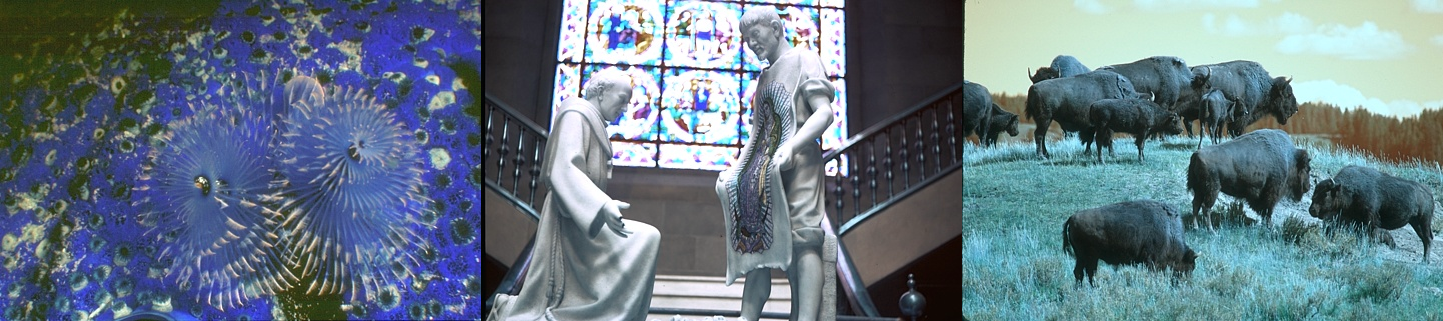

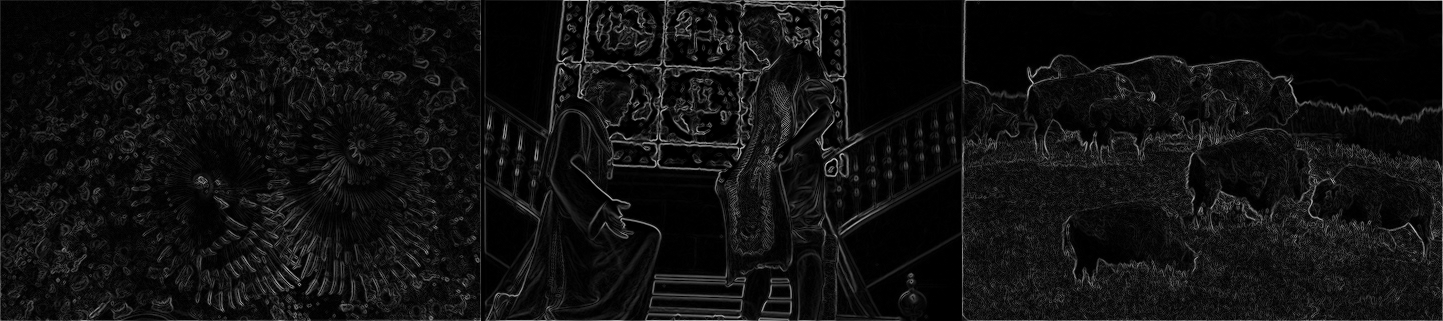

Overall F1 score: 0.4163603293750655


In [1]:
from PIL import Image
import numpy as np
import cv2, os
from scipy.io import loadmat
from scipy import signal
import evaluate_boundaries


N_THRESHOLDS = 99

def detect_edges(imlist, fn):
  images, edges = [], []
  for imname in imlist:
    I = cv2.imread(os.path.join('data', str(imname)+'.jpg'))
    images.append(I)

    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I.astype(np.float32)/255.
    mag = fn(I)
    edges.append(mag)
  return images, edges

def evaluate(imlist, all_predictions):
  count_r_overall = np.zeros((N_THRESHOLDS,))
  sum_r_overall = np.zeros((N_THRESHOLDS,))
  count_p_overall = np.zeros((N_THRESHOLDS,))
  sum_p_overall = np.zeros((N_THRESHOLDS,))
  for imname, predictions in zip(imlist, all_predictions):
    gt = loadmat(os.path.join('data', str(imname)+'.mat'))['groundTruth']
    num_gts = gt.shape[1]
    gt = [gt[0,i]['Boundaries'][0,0] for i in range(num_gts)]
    count_r, sum_r, count_p, sum_p, used_thresholds = \
              evaluate_boundaries.evaluate_boundaries_fast(predictions, gt, 
                                                           thresholds=N_THRESHOLDS,
                                                           apply_thinning=True)
    count_r_overall += count_r
    sum_r_overall += sum_r
    count_p_overall += count_p
    sum_p_overall += sum_p

  rec_overall, prec_overall, f1_overall = evaluate_boundaries.compute_rec_prec_f1(
        count_r_overall, sum_r_overall, count_p_overall, sum_p_overall)
  
  return max(f1_overall)

def compute_edges_dxdy(I):
  """Returns the norm of dx and dy as the edge response function."""
  
  dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same')
  dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same')
  mag = np.sqrt(dx**2 + dy**2)
  mag = normalize(mag)
  return mag

def normalize(mag):
  mag = mag / 1.5
  mag = mag * 255.
  mag = np.clip(mag, 0, 255)
  mag = mag.astype(np.uint8)
  return mag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)

### 3.1 ###

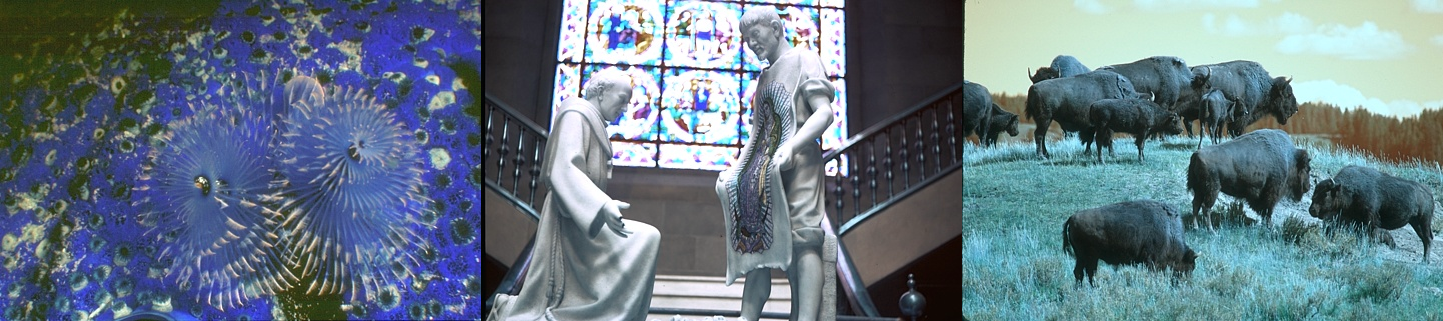

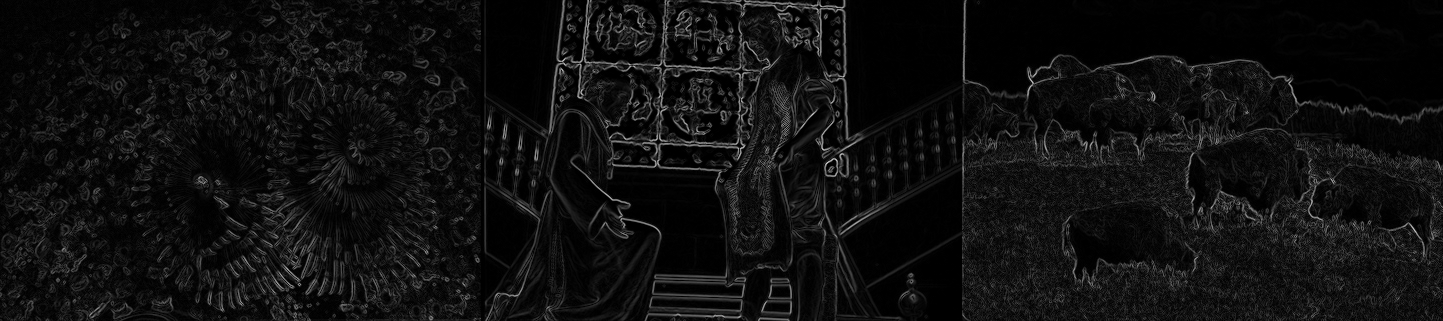

Overall F1 score: 0.4175307435125027


In [2]:
def compute_edges_dxdy_warmup(I):
    """Hint: Look at arguments for scipy.signal.convolve2d"""
    # ADD CODE HERE
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary='symm')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary='symm')
    mag = np.sqrt(dx**2 + dy**2)
    mag = normalize(mag)
    return mag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy_warmup
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)

### 3.2 ###

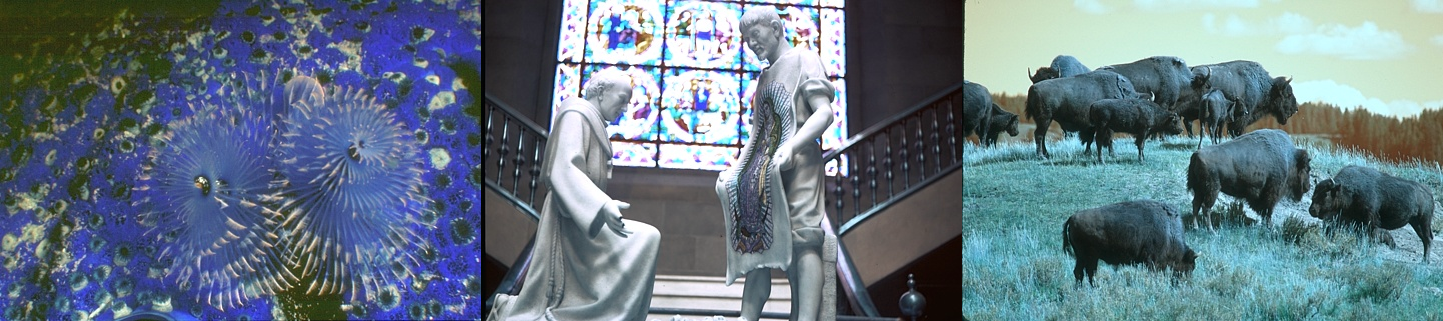

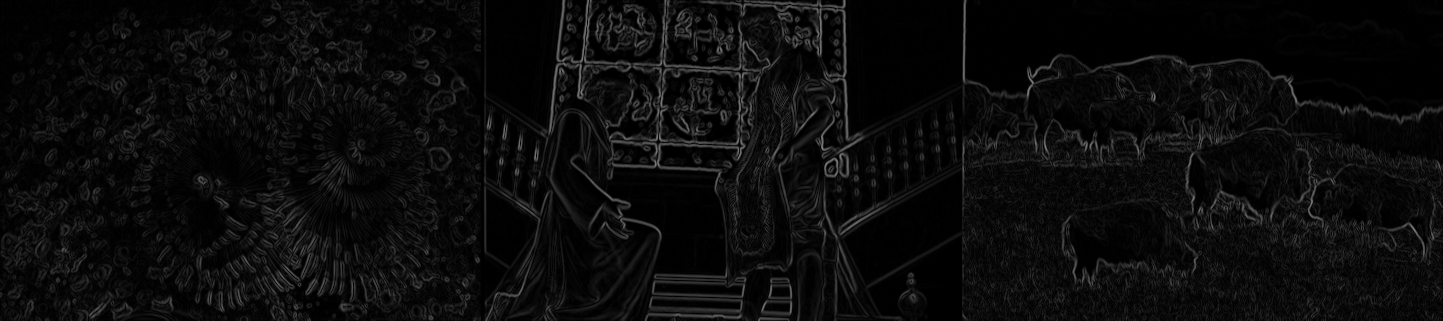

Overall F1 score: 0.42027528550437243


In [3]:
def compute_edges_dxdy_smoothing(I):
    """ Copy over your response from part 3.1 and alter it
    to include this answer. See cv2.GaussianBlur"""
    # ADD CODE HERE
    I = cv2.GaussianBlur(I, (3,3),0.55,0.55, cv2.BORDER_DEFAULT)
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary='symm')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary='symm')
    mag = np.sqrt(dx**2 + dy**2)
    mag = normalize(mag)
    
    return mag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy_smoothing
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)

### 3.3 ###

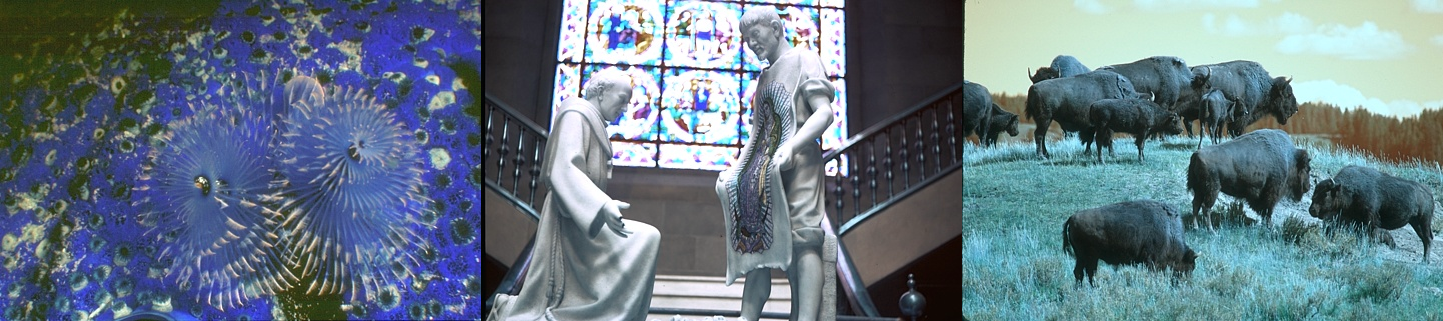

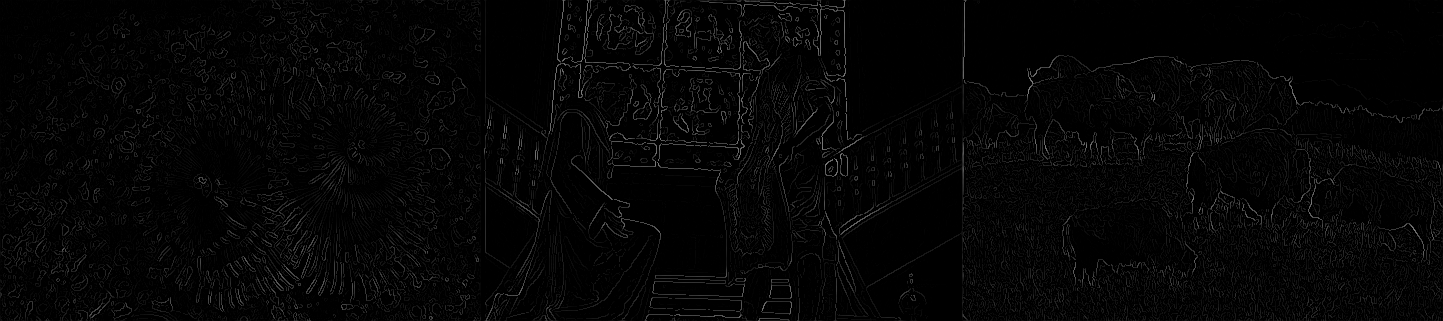

Overall F1 score: 0.4581625651963648


In [4]:
def compute_edges_dxdy_nonmax(I):
    """ Copy over your response from part 3.2 and alter it
    to include this response"""
    # ADD CODE  HERE
    I = cv2.GaussianBlur(I, (3,3),0.55,0.55, cv2.BORDER_DEFAULT)
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same', boundary='symm')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same', boundary='symm')
    mag = np.sqrt(dx**2 + dy**2)
    mag = normalize(mag)
    
    
    threshold = 0
    row,column = mag.shape
    theta = np.arctan2(dx,dy)
    angle = theta * 180/np.pi
    angle[angle < 0] += 180
    #newMag = np.ones((row,column), dtype=np.int32)
    newMag = mag.copy()
    for i in range(1, row-1):
        for j in range(1, column-1):
            neighbor1 = 255
            neighbor2 = 255
            #angle 0 degree
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                neighbor1 = mag[i+1, j].copy()
                neighbor2 = mag[i-1, j].copy()
                
            #angle 45 degree
            elif (22.5 <= angle[i,j] < 67.5):
                neighbor1 = mag[i-1, j-1].copy()
                neighbor2 = mag[i+1, j+1].copy()
               
            #angle 90 degree
            elif (67.5 <= angle[i,j] < 112.5):
                neighbor1 = mag[i, j+1].copy()
                neighbor2 = mag[i, j-1].copy()
               
            #angle 135 degree
            elif (112.5 <= angle[i,j] < 157.5):
                neighbor1 = mag[i-1, j+1].copy()
                neighbor2 = mag[i+1, j-1].copy()

            if (mag[i,j] > neighbor1+threshold) and (mag[i,j] > neighbor2+threshold):
                newMag[i,j] = mag[i,j] 
            else:
                newMag[i,j] = 0
                
    return newMag


imlist = [12084, 24077, 38092]
fn = compute_edges_dxdy_nonmax
images, edges = detect_edges(imlist, fn)
display(Image.fromarray(np.hstack(images)))
display(Image.fromarray(np.hstack(edges)))
f1 = evaluate(imlist, edges)
print('Overall F1 score:', f1)